In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots
from netloader import transforms
from sklearn.decomposition import PCA

from src import main
from src.utils import data, analysis
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

torch.serialization.add_safe_globals([CompactClusterEncoder])
reload(data)
reload(analysis)
reload(main)
# reload(single_plots)
from src.main import init
from src.utils import analysis
from src.utils.data import DarkDataset, loader_init

In [79]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA2100', '#FA7700']
flamingo_test = ['#FA07A0']
colours = ['k'] + flamingo_colours + bahamas_agn_colours + bahamas_colours

In [103]:
data = analysis.batch_train_summary(25, '../data/')

In [104]:
dataset = DarkDataset(
    config['data']['data-dir'],
    ['bahamas_cdm', 'bahamas_cdm_low', 'bahamas_cdm_hi', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1', 'flamingo_low', 'flamingo_hi', 'flamingo'],
    ['noise'],
)
dataset.labels = dataset.unique_labels(dataset.labels, dataset.sims)
images = dataset.images[:, :2].copy()
images.shape

# data = net.predict(loaders[1])
# # data['targets'] = dataset.correct_unknowns(data['targets'].squeeze())
# data['targets'] = data['targets'].squeeze()
# labels = dataset.names[data['ids'][np.unique(
#     data['targets'],
#     return_index=True,
# )[1]].astype(int)]

(39200, 2, 100, 100)

In [23]:
predictions = []

In [ ]:
with open('../data/temp_batch_predictions_25.pkl', 'rb') as file:
    predictions = pickle.load(file).tolist()

In [105]:
if isinstance(predictions, np.ndarray):
    predictions = predictions.tolist()

for i, nets_row in enumerate(data['nets']):
    if len(predictions) <= i:
        predictions.append([])

    for j, nets in enumerate(nets_row):
        if len(predictions[i]) <= j:
            predictions[i].append([])

        if isinstance(nets[0].transforms['inputs'], transforms.MultiTransform):
            nets[0].transforms['inputs'][1]._shape = images.shape[1:]
            dataset.images = nets[0].transforms['inputs'](images.copy())

        loaders = loader_init(dataset, batch_size=config['training']['batch-size'], val_frac=config['training']['validation-fraction'], idxs=nets[0].idxs)

        for k, net in enumerate(nets):
            if len(predictions[i][j]) <= k:
                net.to('cuda')
                predictions[i][-1].append(net.predict(loaders[1]))
                net.to('cpu')
                torch.cuda.empty_cache()

predictions = np.array(predictions)


Training data size: 31360	Validation data size: 7840

Training data size: 31360	Validation data size: 7840
Prediction time: 6.924e-01 s
Prediction time: 5.278e-01 s
Prediction time: 5.172e-01 s
Prediction time: 5.329e-01 s
Prediction time: 5.157e-01 s
Prediction time: 5.136e-01 s
Prediction time: 5.216e-01 s
Prediction time: 5.221e-01 s
Prediction time: 5.136e-01 s
Prediction time: 5.139e-01 s


In [106]:
with open('../data/temp_batch_predictions_25.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [107]:
data_pred = dict(zip(predictions.flatten()[0].keys(), [np.empty_like(predictions) for _ in range(len(predictions.flatten()[0].keys()))]))

for key in data_pred:
    for shape in np.ndindex(predictions.shape):
        data_pred[key][*shape] = predictions[*shape][key].copy()

for key in data_pred:
    try:
        data_pred[key] = np.array(data_pred[key].tolist())
    except ValueError:
        pass

In [108]:
labels = dataset.names[np.unique(dataset.labels, return_index=True)[1]]

In [109]:
data_pred['preds'].shape, data['nets'].shape

((1, 2, 10, 7840, 1), (1, 2, 10))

In [115]:
np.min(data_pred['preds'][0, 0])

np.float64(-0.108856201171875)

In [114]:
for i, (preds, nets) in enumerate(zip(data_pred['preds'][0], data['nets'][0])):
    data_pred['preds'][0, i] = nets[0].transforms['targets'](preds)

/tmp/ipykernel_5798/3952114608.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  data_pred['preds'][0, i] = nets[0].transforms['targets'](preds)


In [116]:
distributions = analysis.distributions(data_pred['preds'].squeeze(axis=-1), dataset.labels[data_pred['ids'].astype(int)].squeeze(axis=-1))
grids, new_distributions = analysis.mult_distributions(distributions)
distributions.shape, new_distributions.shape, grids.shape

((1, 2, 10, 10), (1, 2, 10, 500), (1, 2, 500))

In [117]:
probs = np.empty_like(new_distributions)
cumsums = probs.copy()

for shape in np.ndindex(new_distributions.shape[:-1]):
    probs[*shape] = new_distributions[*shape] / np.sum(new_distributions[*shape])
    cumsums[*shape] = np.cumsum(probs[*shape])

In [118]:
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)
quantiles = np.empty((len(quantile_values), *cumsums.shape[:-1]))

for shape in np.ndindex(cumsums.shape[:-1]):
    grid = data['nets'][*shape[:-1], 0].transforms['targets'](grids[shape[:-1]], back=True)

    for i, percentile in enumerate(quantile_values):
        quantiles[i, *shape] = grid[np.argmin(np.abs(cumsums[*shape] - percentile), axis=-1)]

In [102]:
idxs = data_pred['targets'][0, 0, 0, :, 0] == np.unique(data_pred['targets'][0, 0, 0, :, 0])[-1]
np.mean(data['nets'][0, 0, 0].transforms['targets'](data_pred['preds'][0, 0, 0, idxs, 0], back=True)), data['nets'][0, 0, 0].transforms['targets'](np.mean(data_pred['preds'][0, 0, 0, idxs, 0]), back=True), np.median(data['nets'][0, 0, 0].transforms['targets'](data_pred['preds'][0, 0, 0, idxs, 0], back=True))

(np.float64(0.74465216158222),
 array([0.554338]),
 np.float64(0.7358715783237253))

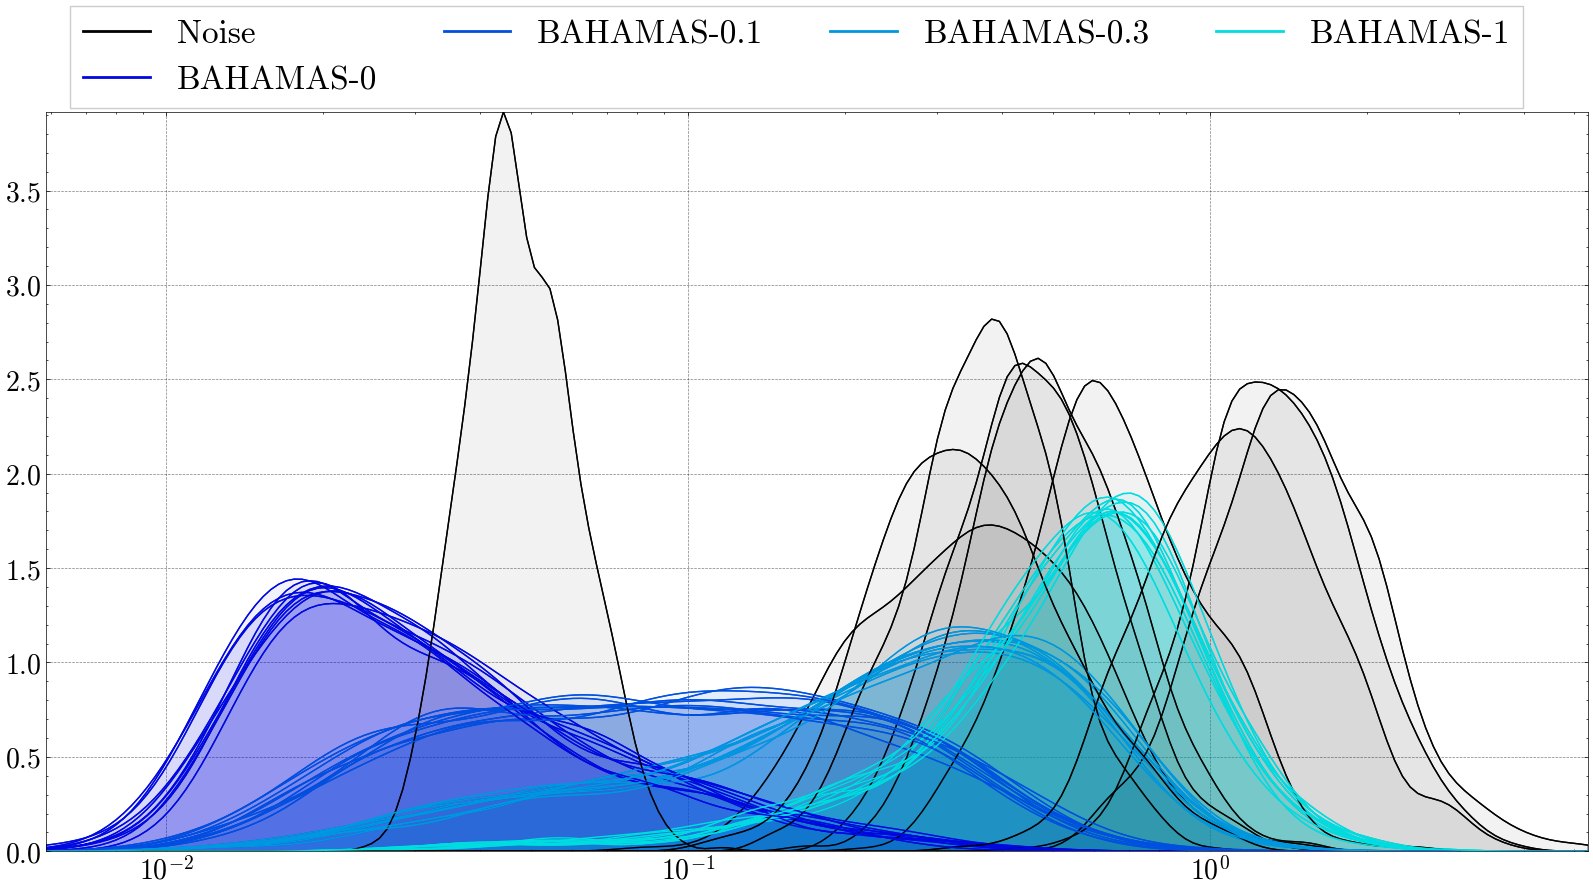

In [138]:
data_idxs = [0, -4, -3, -2, -1]
idx = (-1, 1)
plot = plots.PlotDistribution(
    # [distributions[-1, 0, 0]],
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, data_idxs].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(np.array(colours)[data_idxs], distributions.shape[-2]).tolist(),
    # colours=colours,
    bins=200,
    labels=np.tile(labels[data_idxs], distributions.shape[-2]).tolist(),
    alpha_2d=0.05,
    # fig_size=(8,4),
)

In [ ]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    line.remove()
    poly.remove()
    plot.plots[plot.axes].remove(line)
    plot.plots[plot.axes].remove(poly)

    line.set_ydata(line.get_ydata() / np.sum(line.get_ydata()))
    verts = poly.get_paths()[0].vertices
    verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
    poly.set_verts([verts])

    plot.axes.add_line(line)
    plot.axes.add_collection(poly)
    plot.plots[plot.axes].append(line)
    plot.plots[plot.axes].append(poly)

plot.set_axes_pad()

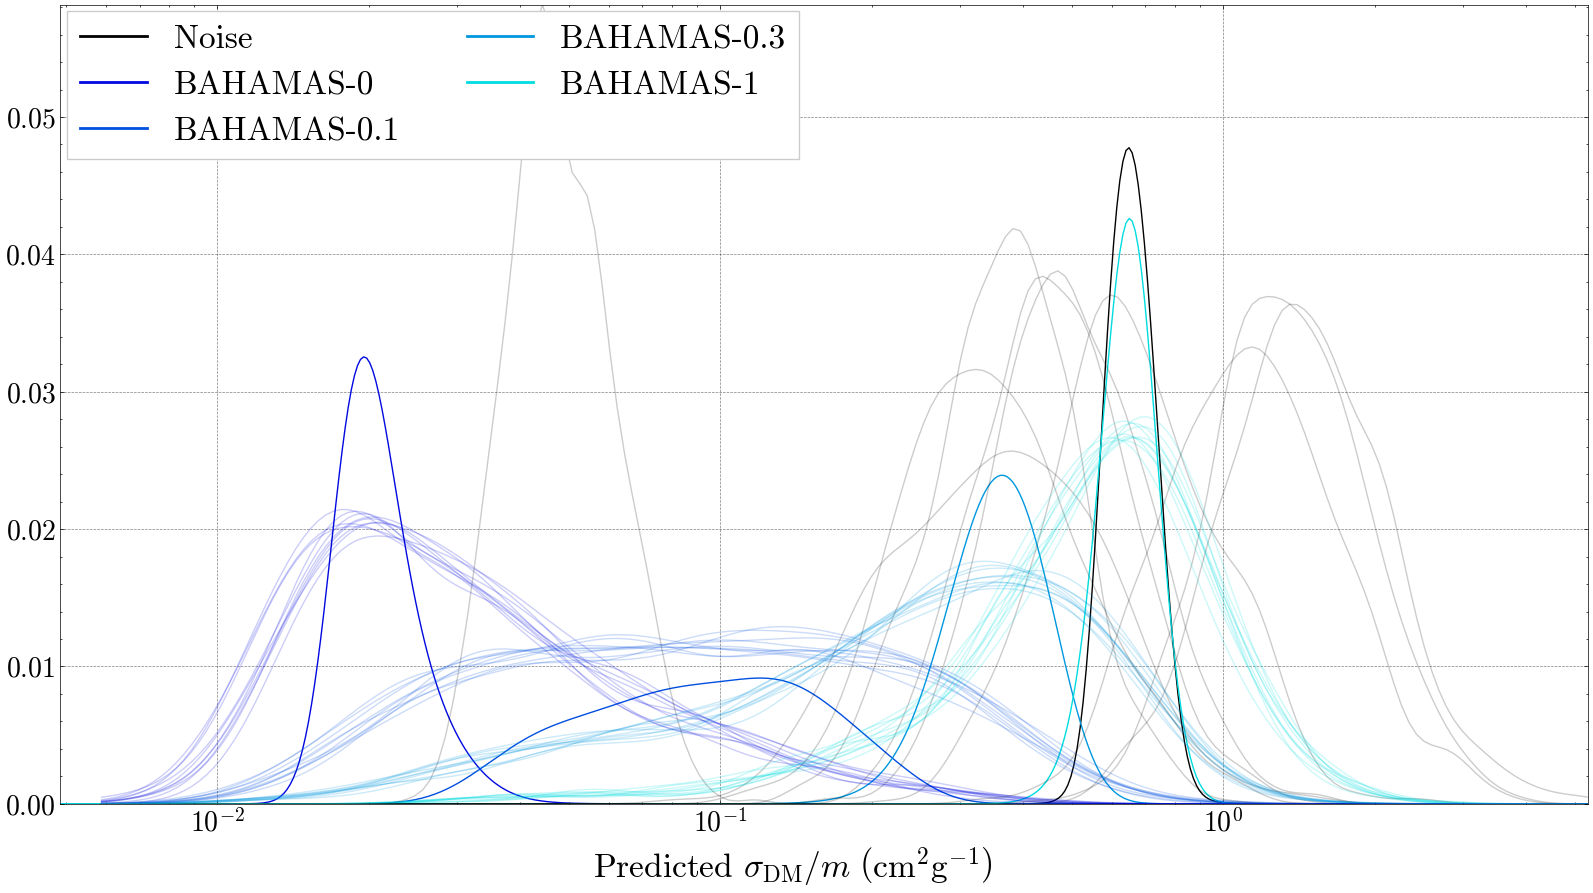

In [140]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    plot2.plots[plot2.axes].append(plot2.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.2)[0])
    # plot2.plots[plot2.axes].append(poly)
    # plot2.axes.add_line(line)
    # plot2.axes.add_collection(poly)

plot2.set_axes_pad()
plot2.fig

(np.float64(0.012641369981139497), np.float64(0.9891628089955289))

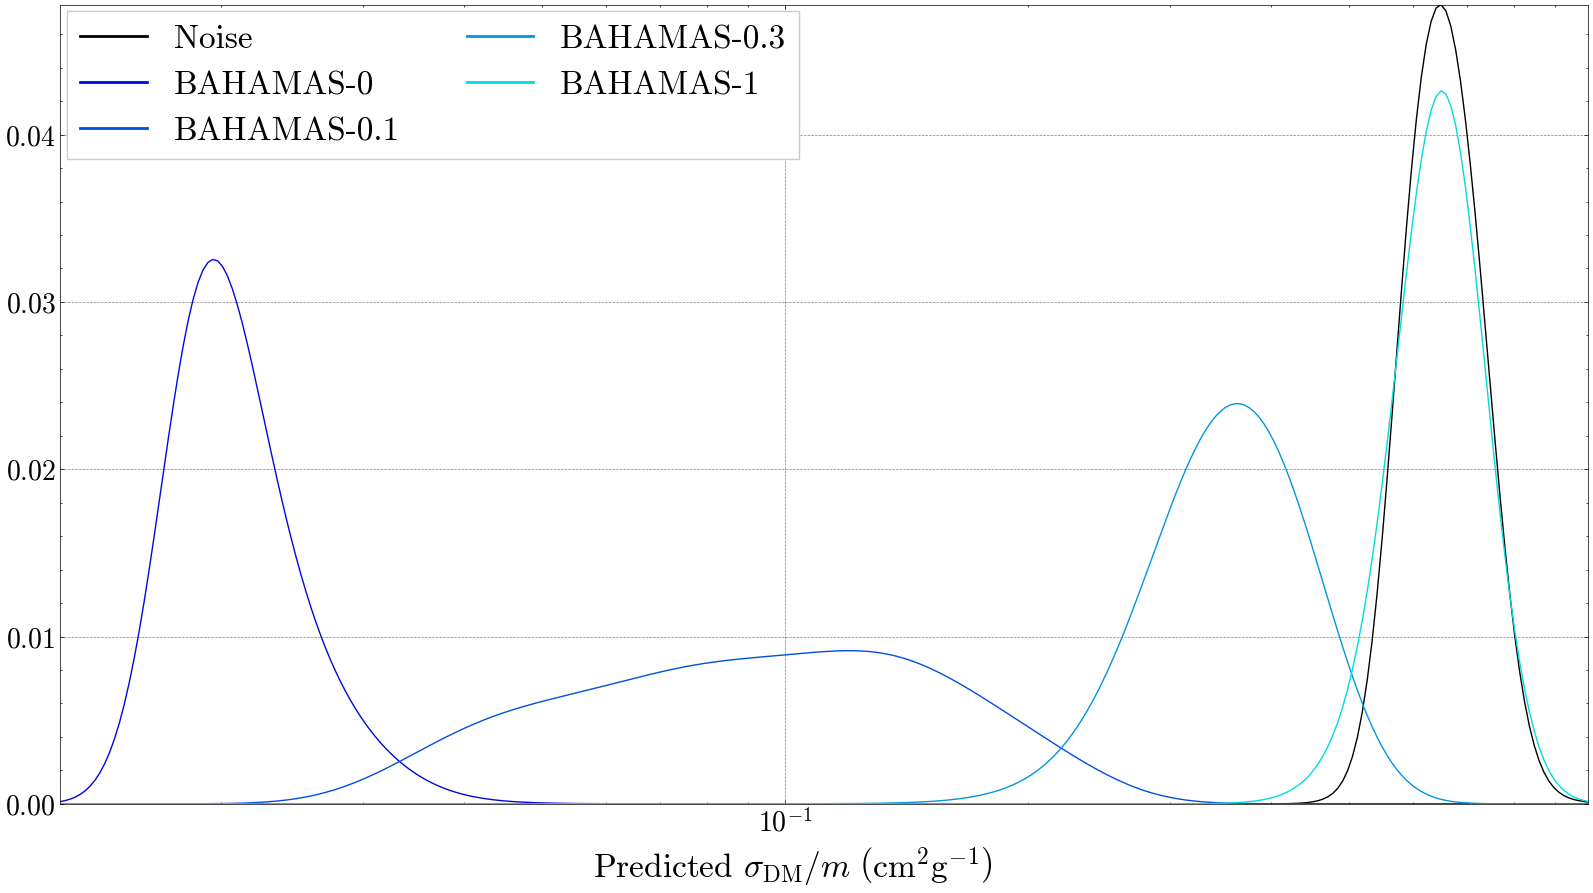

In [133]:
idx = (-1, 1)
plot2 = plots.PlotPlots(
    data['nets'][*idx, 0].transforms['targets'](grids[*idx], back=True),
    probs[*idx, data_idxs],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    markers='',
    labels=labels[data_idxs].tolist(),
    colours=np.array(colours)[data_idxs].tolist(),
    axis=True,
    loc='upper left',
    cols=2,
    # fig_size=(8,4),
)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]))

In [142]:
quantiles[0, -1, 1, 0] - quantiles[2, -1, 1, 0], quantiles[3, -1, 1, 0] - quantiles[0, -1, 1, 0]

(np.float64(0.06891223909510524), np.float64(0.07709089337836439))

In [141]:
idx = (-1, 1)
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in quantile_values]).round(5)

,50%,5%,16%,84%,95%
Noise,0.64956,0.54134,0.58065,0.72665,0.77941
FLAMINGO Low,0.03469,0.02184,0.02478,0.08157,0.12956
FLAMINGO High,0.03057,0.02154,0.02443,0.04994,0.11745
FLAMINGO,0.03234,0.02094,0.02409,0.05282,0.09652
BAHAMAS-0 Low,0.02154,0.01673,0.01846,0.02513,0.02772
BAHAMAS-0 High,0.02215,0.01604,0.01820,0.02733,0.03144
BAHAMAS-0,0.02036,0.01582,0.01721,0.02478,0.02973
BAHAMAS-0.1,0.09254,0.03669,0.04994,0.15988,0.20867
BAHAMAS-0.3,0.35053,0.23344,0.27620,0.43868,0.49767
BAHAMAS-1,0.64051,0.50469,0.55673,0.72665,0.79041


In [36]:
distributions = []

for target in np.unique(data_pred['targets'][0, 0, 0, :, 0]):
    idxs = target == data_pred['targets'][0, 0, 0, :, 0]
    distributions.append(data_pred['preds'][0, 0, 0, idxs, 0].flatten())

In [38]:
np.array(distributions).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [37]:
# idxs = [1, 5, 6, 7, 8, 9]
idxs = np.arange(len(distributions))
plot = plots.PlotDistribution(
    np.array(distributions, dtype=object)[idxs],
    log=True,
    norm=True,
    y_axes=False,
    density=True,
    # axis_pad=False,
    bins=400,
    x_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=np.array(labels)[idxs],
    colours=['k'] + bahamas_colours,
)
plot.axes.set_xlim([np.min(data['preds']), np.max(data['preds'])])
plot.axes.set_ylim([0, 1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(0.0, 1.0)

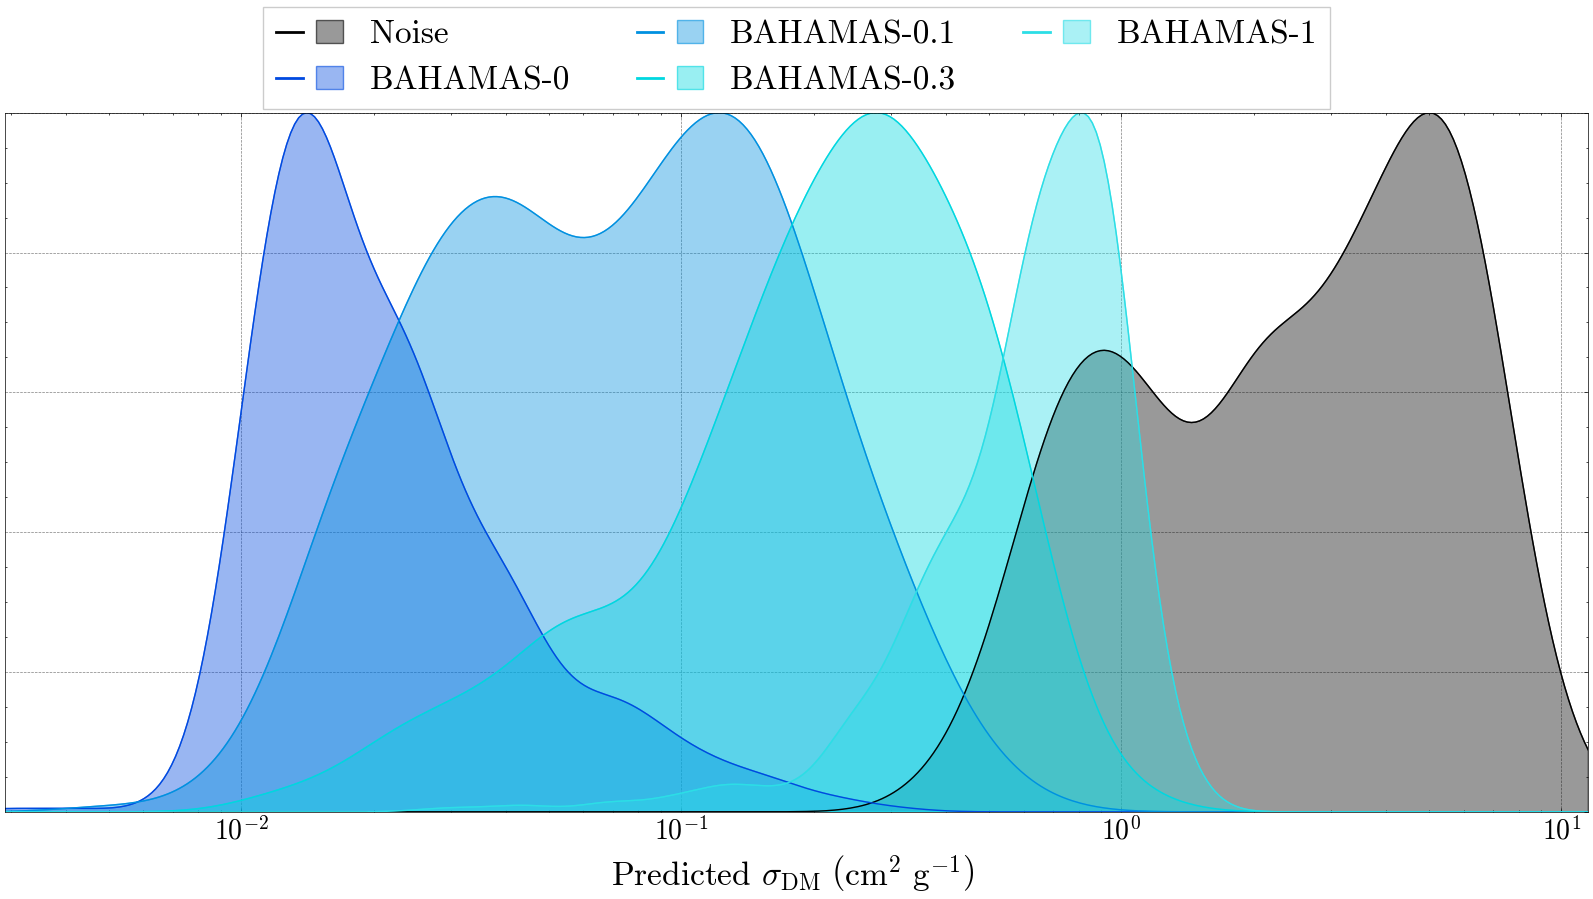

In [19]:
# idxs = [1, 5, 6, 7, 8, 9]
idxs = np.arange(len(distributions))
plot = plots.PlotDistribution(
    np.array(distributions, dtype=object)[idxs],
    log=True,
    norm=True,
    y_axes=False,
    density=True,
    # axis_pad=False,
    bins=400,
    x_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=np.array(labels)[idxs],
    colours=['k'] + bahamas_colours,
)
plot.axes.set_xlim([np.min(data['preds']), np.max(data['preds'])])
plot.axes.set_ylim([0, 1])

In [20]:
plot.savefig('../plots/', name='test')